# Caso de estudio: Clasificación Binaria

En este documento se presenta un conjunto de datos de pueba conocido como _FourClass_ presentado en la referencia (1) de este
documento. El propósito es comparar el resultado y eficiencia de los siguientes métodos:

- **Clasificador euclidiano**
- **Gaussian Naive Bayes**
- **k-Nearest Neighbors**

## _FourClass_

Este conjunto de datos cuenta con dos características principales, es un problema de **clasificación binaria**, esto es, solamente
existen dos clases diferentes dentro del conjunto de datos. Algunas características principales de este conjuto de datos son:

- **No** es linealmente separable
- Tiene una distribución espacial _irregular_, esto es, no sigue algún patrón específico.
- Existen regiones y secciones no conexas, esto es, aunque un subconjunto de datos pertenece a una clase particular
  no está dentro del mismo conjunto de puntos.

Como se puede ver este es un conjunto de puntos difícil de clasificar y es un caso de estudio importante para tanto para analizar
como para comprender el verdadero alcance de los métodos de clasificación usuales.

## Precisión de los clasificadores

En general no se sabe la eficiencia de los clasificadores dado un conjunto de datos; pero normalmente se realizan pruebas con conjuntos
de datos que se ha realizado en alguna prueba o experimento. Siempre es útil revisar la literatura para este tipo de problemas. En especial,
en este ejemplo existen muchos experimentos realizados para este conjunto de datos pero aquí se van a hacer algunas hipótesis sobre la verdadera
**eficiencia** esperada de los clasificadores.

- **Clasificador euclidiano:** Dado que este clasificador espera que el conjunto de datos tengan clases _linealmente separables_ se espera que este
  clasificador tenga la peor precisión de todos los métodos presentados en este documento; existen técnicas alternativas para cambiar este tipo
  de conjuntos de datos a espacios donde sí sea _linealmente separable_, pero se estudiarán en algún otro documento.

- **Gaussian Naive Bayes** Este clasificador espera un conjunto de datos con una alta dimensionalidad, que el conjunto de datos contenga clases
  provenientes de distribuciones normales Gaussianas entre otras cosas. Este conjunto de datos no contiene ninguna de estas condiciones, por lo que
  es posible que este clasificador tenga una baja precisión.

- **k-Nearest Neighbors** Este clasificador no tiene ninguna condición excepto que no sea un conjunto de datos con alta dimensionalidada tal que
  el _k-d tree_ que utiliza para la búsqueda de los vecinos más cercanos no se pueda implementar por su baja eficiencia. Por lo tanto se espera
  que este sea el clasificador con la mejor precisión de todos dado que no depende de la distrución espacial del conjunto de datos.

In [2]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (21, 10)

import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Cargar el archivo de datos que está dentro del repositorio
datos = np.loadtxt(
    os.path.relpath("datasets/fourclass.csv", start="intelicompu"),
    delimiter=",",
    skiprows=1
)

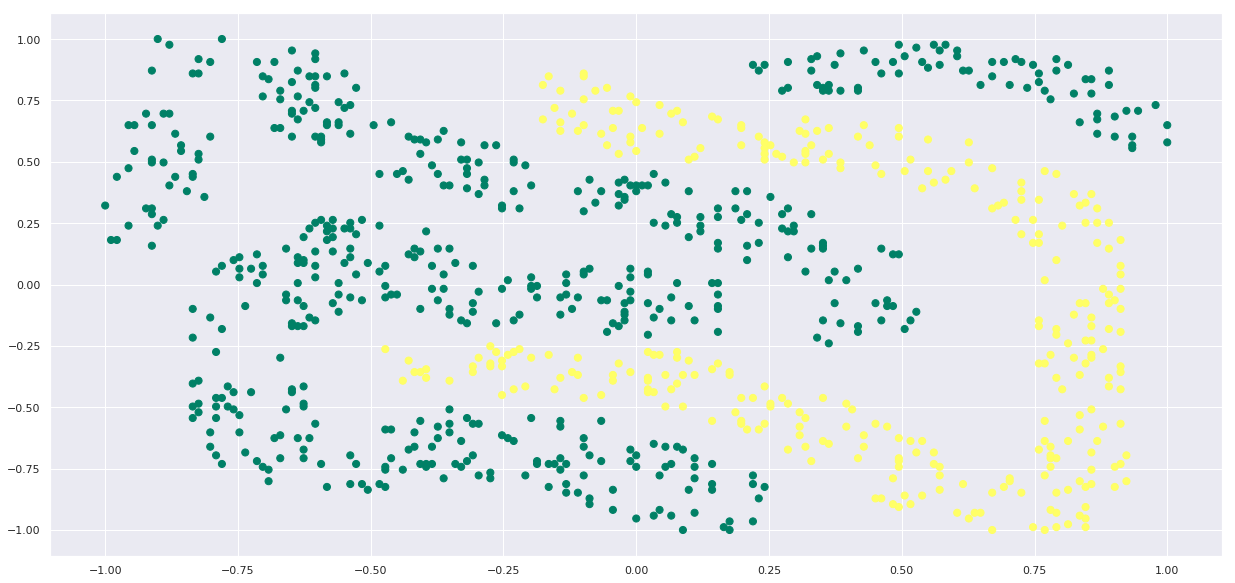

In [4]:
# Separar los datos y las etiquetas
X = datos[:, :-1]
# Las etiquetas corresponden a la última fila de los datos
y = datos[:, -1]
# Graficar los datos
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="summer")

Como se puede ver en la figura, las clases están separadas por color, existen 2 y tal como se describe en la introducción de este documento existen regiones donde los datos no están en el mismo conglomerado de datos según la clase.

Claramente no es _linealmente separable_, no se tienen tantos puntos y solamente existen dos características.

In [5]:
# Sustituir el nombre de la clase para evitar ciertos errores
y[y == -1] = 0
# Separar los datos para predicción y entrenamiento
x_entre, x_prueba, y_entre, y_prueba = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=False)

**NOTA:** Se sustituye la clase -1 por 0 para evitar problemas numéricos dentro de las implementaciones de los métodos de clasificación. No siempre es necesario hacer este tipo de modificaciones, depende del conjunto de datos, la persona a cargo de realizar el estudio de los datos, entre otras cosas.

 ## Clasificador euclidiano

In [6]:
# Cargar el código que está dentro del directorio
%run DiscriminanteLineal.py

In [7]:
# Instanciar, entrenar y realizar la clasificación
euclidiano = DiscriminanteLineal()
euclidiano.entrenamiento(x_entre, y_entre)
resultado = euclidiano.prediccion(x_prueba)

In [8]:
# Crear el reporte de clasificación
print(classification_report(y_prueba, resultado, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       156
           1       0.80      0.50      0.61       103

   micro avg       0.75      0.75      0.75       259
   macro avg       0.77      0.71      0.71       259
weighted avg       0.76      0.75      0.73       259



### Precisión y resultados

El _reporte de clasificación_ para este clasificador produce valores interesantes. Este clasificador puede clasificar correctamente la _clase 0_ cuando se presenta sola, pero cuando tiene que discernir entre la _clase 1_ y la _clase 0_ tiene un bajo desempeño.

Este era de esperarse dado que no existe una separación lineal entre las clases, solamente algunas regiones espaciales dentro del conjunto de datos se pueden considerar tal que pasa una línea recta entre ellas, pero en general esto no es cierto.

Sin embargo, para ser un clasificador totalmente lineal, tiene un desempeño adecuado pero deficiente.

 ## k-Nearest Neighbors

In [9]:
# Cargar el código que está dentro del directorio
%run kNearestNeighbors.py

In [10]:
# Instanciar, entrenar y realizar la clasificación
knn_clf = kNearestNeighbors(num_vecinos=5)
knn_clf.entrenamiento(x_entre, y_entre)
resultado = knn_clf.predecir(x_prueba)

**NOTA:** Sobre el número de vecinos `num_vecinos` se eligió el valor de 5 por coveniencia, sin embargo lo correcto es realizar algún tipo de _validación_ o técnica de ajuste para que este valor sea el que proporcione los mejores resultados de clasificación.

In [11]:
print(classification_report(y_prueba, resultado, labels=[0, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       103

   micro avg       1.00      1.00      1.00       259
   macro avg       1.00      1.00      1.00       259
weighted avg       1.00      1.00      1.00       259



### Precisión y resultados

Como era de esperarse, este clasificador realiza una clasifición perfecta de los datos. No solamente puede clasificar correctamente entre clases, sino que también puede distinguir entre una y otra. Esto se debe claramente a la naturaleza de este clasificador dado que no requiere de ninguna hipótesis sobre los datos, solamente importa qué tipo de vecino está cerca y a qué clase pertenece.

 ## Gaussian Naive Bayes

In [12]:
# Cargar el código que está dentro del directorio
%run GNaiveBayes.py

In [13]:
# Instanciar, entrenar y realizar la clasificación
gnb_clf = GNaiveBayes()
gnb_clf.entrenamiento(x_entre, y_entre)
resultado = gnb_clf.prediccion(x_prueba)

In [14]:
# Crear el reporte de clasificación
print(classification_report(y_prueba, resultado, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       156
           1       0.89      0.54      0.67       103

   micro avg       0.79      0.79      0.79       259
   macro avg       0.82      0.75      0.76       259
weighted avg       0.81      0.79      0.78       259



### Precisión y resultados

Mejor que el _clasificador euclidiano_ pero los resultados siguen siendo decepcionantes. Sin lugar a dudas este clasificador tendría buenos resultados con este conjunto de datos si existiera un mayor número de elementos para entrenamiento y prueba.

Es posible que su precisión se deba a que los datos en realidad _sí_ provienen de una distribución normal, simplemente no lo aparentan en la figura representativa; esto por que tiene mejor desempeño que el _clasificador lineal_ pero tampoco puede distinguir correctamente entre clases.

 ## Referencias

 1. Artículo original de donde se obtuvo el conjunto de datos Four Class
   Ho, Tin Kam, and Eugene M. Kleinberg. "Building projectable classifiers of arbitrary complexity." Proceedings of 13th International Conference on Pattern Recognition. Vol. 2. IEEE, 1996.